In [1]:
import os
import json
import random

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from keras.models import Sequential
from keras import layers

random.seed(1337)

Using TensorFlow backend.


In [2]:
def data_from_file(file, filter_silence=True):
    # Read json sequence data
    with open(file) as f:
        data = np.array(json.load(f))
        if filter_silence:
            # Filter out "silence" targets (1, 1)
            data = np.array([p for p in data if p[1][0] != 1 and p[1][1] != 1])
    return data

def add_noise(data, noise=0.01):
    x = data[0] + random.uniform(-noise, noise)
    y = data[1] + random.uniform(-noise, noise)
    return [min(1.0, x), min(1.0, y)]

def data_test(size=10000, noise=0):
    data = []
    for i in range(size):
        x = (i % 100) / 100.0
        y = (i % 50) / 50.0
        original = add_noise([x, y], noise)
        target = [original[1], original[0]]
        data.append([original, target])
    return np.array(data)

def enhance_data(data, factor, noise):
    new_data = data
    for _ in range(factor):
        arr = np.array([[add_noise(p[0], noise),
                              add_noise(p[1], noise)] for p in data])
        new_data = np.concatenate((arr, new_data), axis=0)
    return new_data

In [3]:
# Hyperparameters
# ======================================================================
grid_size = 5            # Grid size for data encoding

batch_size = 128         # How many samples are in a batch
seq_len = 16             # How long is the sequence / sample to train
data_split = 0.2         # Percentage for validation & testing set
shuffle = False          # Randomly shuffle training data

num_layers = 1           # Number of hidden LSTM layers
num_units = 256          # Number of units per LSTM layer
epochs = 10              # How many epochs to train

temperature = 1          # Softmax distribution temperature for sampling

# Data sources
# ======================================================================
# data = data_test(size=20000, noise=0.01)
# data = data_from_file('./files/json/sequence.json')
# data = data_from_file('./files/json/sequence2.json')
data = data_from_file('./files/json/sequence3.json')
# data = enhance_data(data, factor=10, noise=0.25)

In [4]:
def encode_point(p, grid_size):
    return [min(round(grid_size * max(f, 0)), grid_size - 1) for f in p]

def decode_point(p, grid_size):
    return [f / grid_size for f in p]

def encode_data(data, grid_size):
    '''Encode 2D positions into a grid and convert this to index values'''
    new_data = []
    m = np.zeros((grid_size, grid_size))
    for column in data:
        new_column = []
        for point in column:
            ac_converted = np.array(encode_point(point, grid_size), dtype='int32')
            ac_indexed = np.ravel_multi_index(ac_converted, m.shape)
            new_column.append(ac_indexed)
        new_data.append(new_column)
    return np.array(new_data)

def decode_data(data, grid_size):
    '''Decode indexed grid positions to (x, y) float values'''
    new_data = []
    m = np.zeros((grid_size, grid_size))
    for column in data:
        new_column = []
        for ac_converted in column:
            unraveled = np.unravel_index(ac_converted, m.shape)
            point = np.array(decode_point(unraveled, grid_size), dtype='float32')
            new_column.append(point)
        new_data.append(new_column)
    return np.array(new_data)

encoded_data = encode_data(data, grid_size)
decoded_data_test = decode_data(encoded_data, grid_size)
num_classes = grid_size ** 2

print('Number of classes:', num_classes)
print('Data size:', len(data))

Number of classes: 25
Data size: 35999


In [5]:
# Show an example on how the data looks now
test_index = 0
print('Original:', data[test_index])
print('Encoded:', encoded_data[test_index])
print('Decoded:', decoded_data_test[test_index])

Original: [[0.46392624 0.26740089]
 [0.44737112 0.24449598]]
Encoded: [11 11]
Decoded: [[0.4 0.2]
 [0.4 0.2]]


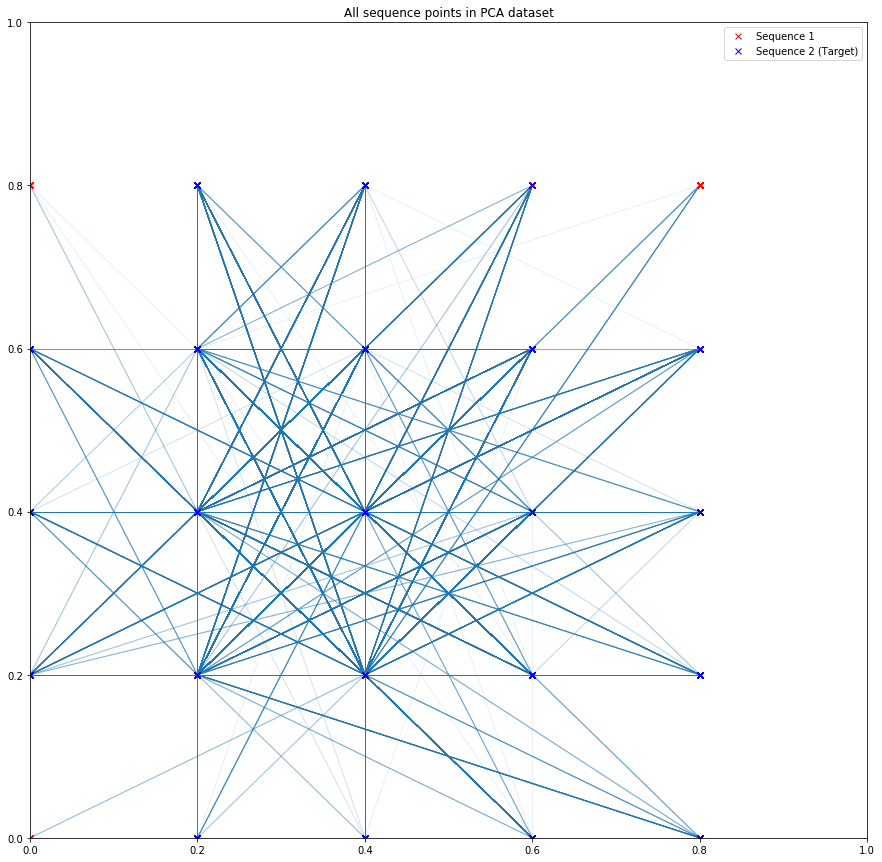

In [6]:
# Plot PCA coordinate data
plot_data = decoded_data_test

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('All sequence points in PCA dataset')
ax.axis([0.0, 1.0, 0.0, 1.0])

ax.plot(plot_data[:,0,0], plot_data[:,0,1], 'rx', label='Sequence 1')
ax.plot(plot_data[:,1,0], plot_data[:,1,1], 'bx', label='Sequence 2 (Target)')

lines = [[p[0], p[1]] for p in plot_data]
lc = mc.LineCollection(lines, linewidths=1, alpha=0.1)
ax.add_collection(lc)

ax.legend()
plt.show()

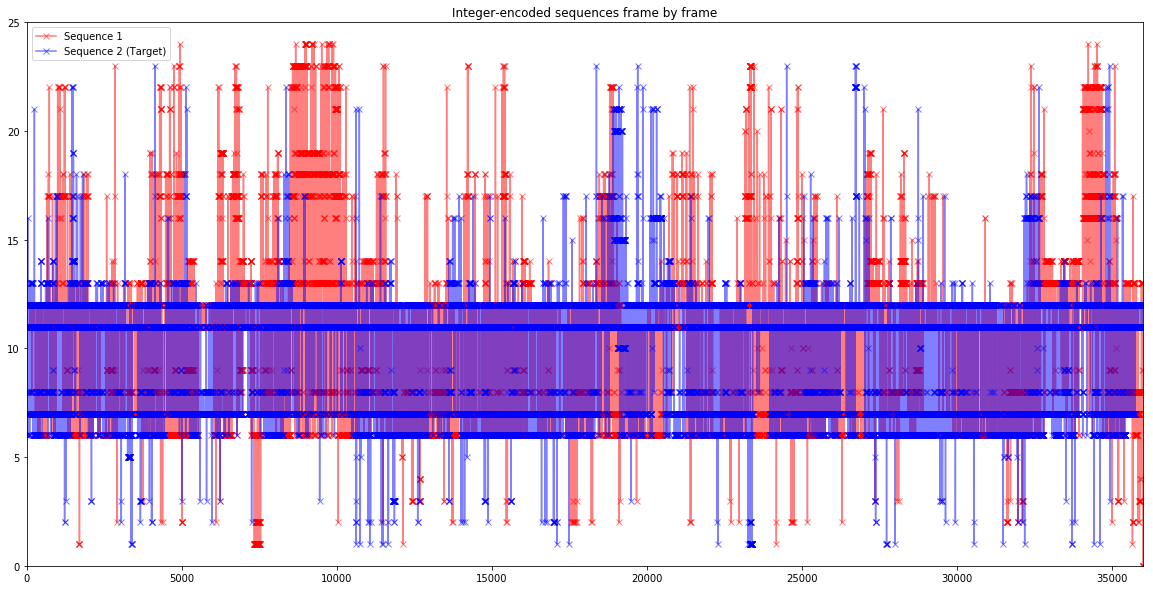

In [7]:
# Plot sequence data
sequence1 = encoded_data[:, 0]
sequence2 = encoded_data[:, 1]

plt.figure(figsize=(20, 10))

plt.plot(range(len(sequence1)), sequence1, color='red', marker='x', label='Sequence 1', alpha=0.5)
plt.plot(range(len(sequence2)), sequence2, color='blue', marker='x', label='Sequence 2 (Target)', alpha=0.5)

plt.legend(frameon=True)
plt.title('Integer-encoded sequences frame by frame')
plt.axis([0, max(len(sequence1), len(sequence2)), 0, num_classes])

plt.show()

In [8]:
def generator(data, seq_len, min_index, max_index, shuffle=False):
    i = min_index
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), seq_len), dtype='int32')
        targets = np.zeros((len(rows)), dtype='int32')
        for j, _ in enumerate(rows):
            indices = range(rows[j], rows[j] + seq_len)
            if indices[-1] < max_index:
                samples[j] = data[:, 0][indices]
                targets[j] = data[:, 1][indices][-1]
        yield samples, targets

In [9]:
# Split in 3 sets for training, validation and testing
validation_steps = round((data_split / 2) * len(data))

train_max = len(data) - (validation_steps * 2)
val_min = train_max + 1
val_max = train_max + validation_steps + 1
test_min = train_max + validation_steps + 2
test_max = len(data) - 1

training_steps = test_max - test_min

train_gen = generator(encoded_data,
                      seq_len=seq_len,
                      min_index=0,
                      max_index=train_max,
                      shuffle=shuffle)

val_gen = generator(encoded_data,
                    seq_len=seq_len,
                    min_index=val_min,
                    max_index=val_max)

test_gen = generator(encoded_data,
                     seq_len=seq_len,
                     min_index=test_min,
                     max_index=test_max)

steps_per_epoch = train_max // batch_size

print('Batch size:', batch_size)
print('Steps per epoch:', steps_per_epoch)

print('\nSplit for validation & test @ {0:.2f}%'.format(data_split * 100))
print('Training set:', (0, train_max))
print('Validation set:', (val_min, val_max))
print('Test set:', (test_min, test_max))

Batch size: 128
Steps per epoch: 224

Split for validation & test @ 20.00%
Training set: (0, 28799)
Validation set: (28800, 32400)
Test set: (32401, 35998)


In [10]:
model = Sequential()
model.add(layers.Embedding(input_dim=num_classes,
                           output_dim=num_units,
                           input_length=seq_len))
for n in range(num_layers - 1):
    model.add(layers.LSTM(num_units, return_sequences=True))
model.add(layers.LSTM(num_units))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 256)           6400      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 25)                6425      
Total params: 538,137
Trainable params: 538,137
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=validation_steps)

Epoch 1/10
224/224 [==============================] - 442s 2s/step - loss: 1.8291 - acc: 0.3107 - val_loss: 1.5318 - val_acc: 0.3861
Epoch 2/10
224/224 [==============================] - 423s 2s/step - loss: 1.7233 - acc: 0.3233 - val_loss: 1.5448 - val_acc: 0.3862
Epoch 3/10
223/224 [============================>.] - ETA: 0s - loss: 1.7133 - acc: 0.3151

KeyboardInterrupt: 

In [ ]:
# Plot validation and training loss
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
def reweight_distribution(original_distribution, temperature):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

# Calculate scores with training set
scores = []
points = []
points_targets = []
max_dist = .25

for i in range((training_steps // batch_size)):
    # Predict point from model
    samples, targets = next(test_gen)
    results = model.predict(samples)
    
    for j, result in enumerate(results):
        # Reweight the softmax distribution
        result_reweighted = reweight_distribution(result, temperature)
        result_value = np.argmax(result_reweighted)
        
        # Decode data
        position = decode_data([[result_value]], grid_size).flatten()
        position_target = decode_data([[targets[j]]], grid_size).flatten()
        points.append(position)
        points_targets.append(position_target)

        # Calculate distance between prediction and actual test target
        dist = max_dist - min(max_dist, np.linalg.norm(position - position_target))
        scores.append(0.0 if dist == 0.0 else dist / max_dist)
        
points = np.array(points)
points_targets = np.array(points_targets)
score = np.average(scores)

print('Score: {0:.2f}%'.format(score * 100))

In [ ]:
# Plot model prediction results
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Test targets and model predictions')
ax.axis([0.0, 1.0, 0.0, 1.0])

lines = [[points_targets[i], points[i]] for i in range(len(points))]
lc = mc.LineCollection(lines, linewidths=1)
lc.set_array(np.array(scores))
lc.set_clim(0.0, 1.0)
lc.set_cmap('plasma')
ax.add_collection(lc)

axcb = fig.colorbar(lc)
axcb.set_label('Score')

ax.plot(points_targets[:,0], points_targets[:,1], 'rx', label='Target')

colors = np.array([[s, 0, 0] for s in scores])
ax.scatter(points[:,0], points[:,1], label='Result', color='r', marker='^')

ax.legend()
plt.show()